Reference: https://pennylane.ai/qml/demos/tutorial_quantum_natural_gradient  

최근에는 VQA에서 기울기-free한 Nelder-Mead 알고리즘 등이 등장하긴 했으나, parameter-shift rule이 자동으로 analytic gradient를 구할 수 있어 더 보편화됨. 그러나 gradient descent 방법의 한가지 통고는, 어떻게 VQA를 위한 최적의 step size를 구할 것인가임


### The natural gradient  
표준 경사 하강법은 다음과 같음
$$\theta_{t+1} = \theta_{t}-\eta\nabla L (\theta)$$
위 방식의 한계는, 이 접근 자체가 이미 parameter space의 Euclidean geometry에 크게 의존한다는 것. parametrization은 unique하지 않으며, different parametrization이 최적화 landscape의 거리를 왜곡할 수도 있음.  

예시로, 손실 함수 $L$에 대하여, 두 개의 다른 좌표계 시스템으로 파라미터화 되면:
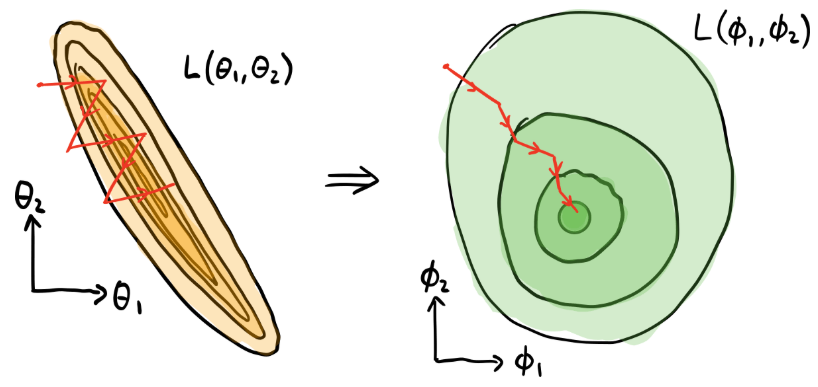 
경사 하강을 $\theta$ 파라미터 고간에서 하면, 각 파라미터를 same Euclidean 거리로 업데이트하는데, 이는 각 파라미터에 대해 손실함수 변화 rate가 다른 것을 고려하지 못함. 대신 $\phi$ 공간에서 한다면, 손실 함수는 그대로지만, nicer geometry를 사용하여 faster convergence로 유도 가능.  

하지만, 그냥 파라미터 공간에서의 경사하강법 자체를 피하면? If we instead consider the optimization problem as a probability distribution of possible output values given an input (i.i., MLE), a better apporoach is to perform the gradient descent in the *distribution* space. 분포 공간은 무차원이고, invarient하기 때문에 각 최적화 스텝은 optimum step-size for every parameter일 것  

고전 NN에서는, 이 기법이 *natural gradient descent*라고 불림.  
$$\theta_{t+1} = \theta_{t}-\eta F^{-1}\nabla L(\theta)$$
$F$는 Fisher information matrix인데, metric tensor처럼 작동함, transforming the steepest descent in the Euclidean parameter space to the steepeset descent in the distribution space

### The quantum analog
양자 상태 공간은 Fubini-Study metric tensor $g_{ij}$라는 unique invariant metric tensor를 보유 함. 이를 quantum natural graient를 구성하는데 쓸 수 있음  
$$\theta_{t+1}=\theta-\eta g^{\dagger}(\theta_t) \nabla L(\theta)$$
where $g^\dagger$ refers to the pseudo-inverse

## Block-diagonal metric tensor  
A block-diagonal approximation to the Fubini-study metric tensor of a VQC는 양자 하드웨어에서 계산 가능. 

다음 VQC에 대해
$$U(\theta)|\psi_0\rangle = V_L(\theta_L)W_L V_{L-1} (\theta_{l-1}) W_{L-1} \dots V_l(\theta_l)W_l \dots V_0(\theta_0)W_0|\psi_0\rangle$$
where
* $|\psi_0\rangle$ is the initial state
* $W_l$ are layers of non-parametrized quantum gates
* $V_l(\theta_l)$ are layers of parametrized quantum gates with $n_l$ parameters $\theta_l = \{\theta_0^l, \dots, \theta_n^l\}$  

그리고 모든 파라미터 게이트를 $X(\theta_i^l) = e^{i\theta_i^l K_i^l}$ 형태로 쓸 수 있다고 하자, where $K_i^l$ is the *generator* of the parametrized operation  

For each parametric layer $l$ in the VQC, the $n_l \times n_l$ block-diagnonal submatrix of the Fubini-Study tensor $g_{ij}^l$ is calculated by:
$$ g_{ij}^l = \langle\psi_{l-1}|K_i K_j|\psi_{l-1} \rangle - \langle\psi_{l-1}|K_i|\psi_{l-1}\rangle\langle\psi_{l-1}|K_j|\psi_{l-1}\rangle $$
where 
$$|\psi_{l-1}\rangle = V_{l-1}(\theta_{l-1})W_{l-1} \dots V_0(\theta_0)W_0|\psi_0\rangle$$
즉 l번째 파라미터 층을 가하기 전의 양자 상태임. 

In [2]:
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp

dev = qml.device("lightning.qubit", wires=3)


@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit(params):
    # |psi_0>: state preparation
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)

    # V0(theta0, theta1): Parametrized layer 0
    qml.RZ(params[0], wires=0)
    qml.RZ(params[1], wires=1)

    # W1: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    # V_1(theta2, theta3): Parametrized layer 1
    qml.RY(params[2], wires=1)
    qml.RX(params[3], wires=2)

    # W2: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    return qml.expval(qml.PauliY(0))

# Use pennylane.numpy for trainable parameters
params = pnp.array([0.432, -0.123, 0.543, 0.233])

위 회로는 4개 파라미터, 2개의 parameter layer 구조임
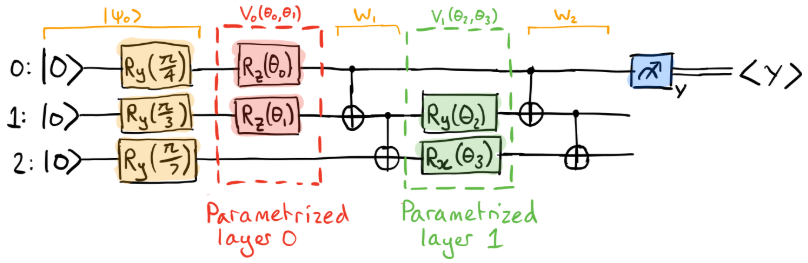
참고로 위에서 $W_0$는 identity임. Since there are two layers, each with two parameters, the block-diagonal approximation consists of two $2\times2$ matrices, $g^0, g^1$.  
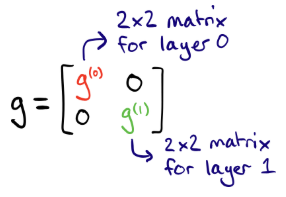

$g^0$을 계산하려면, subcircuit consisting of all gates prior to the layer만들고, generator에 상응하는 observable을 만들어야 함  
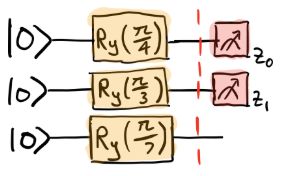

In [3]:
g0 = np.zeros([2, 2])


def layer0_subcircuit(params):
    """This function contains all gates that
    precede parametrized layer 0"""
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)

We then post-process the measurement results in torder to determine $g^0$ as follows,
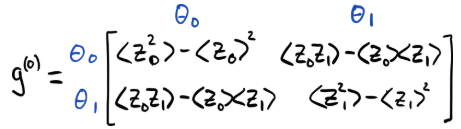

In [6]:
@qml.qnode(dev, interface="autograd")
def layer0_diag(params):
    layer0_subcircuit(params)
    return qml.var(qml.PauliZ(0)), qml.var(qml.PauliZ(1))


# calculate the diagonal terms
varK0, varK1 = layer0_diag(params)
g0[0, 0] = varK0 / 4 # qml.RZ 등은 e^{-i theta P/2}형태로, 1/2가 있는데 K = -P/2라서 4로 나누어야 함
g0[1, 1] = varK1 / 4

The following two subcircuits are then used to calculate the off-diagonal

In [11]:
@qml.qnode(dev, interface="autograd")
def layer0_off_diag_single(params):
    layer0_subcircuit(params)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))


@qml.qnode(dev, interface="autograd")
def layer0_off_diag_double(params):
    layer0_subcircuit(params)
    ZZ = np.kron(np.diag([1, -1]), np.diag([1, -1]))
    return qml.expval(qml.Hermitian(ZZ, wires=[0, 1]))


# calculate the off-diagonal terms
exK0, exK1 = layer0_off_diag_single(params)
exK0K1 = layer0_off_diag_double(params)

g0[0, 1] = (exK0K1 - exK0 * exK1) / 4
g0[1, 0] = (exK0K1 - exK0 * exK1) / 4

block-diagonal은 must be real and symmetric.  
$g^1$에 대해서도 동일하게 가능  
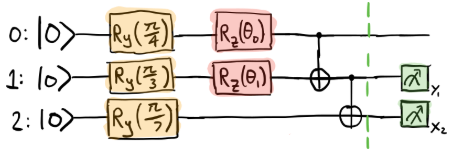

In [13]:
g1 = np.zeros([2, 2])


def layer1_subcircuit(params):
    """This function contains all gates that
    precede parametrized layer 1"""
    # |psi_0>: state preparation
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)

    # V0(theta0, theta1): Parametrized layer 0
    qml.RZ(params[0], wires=0)
    qml.RZ(params[1], wires=1)

    # W1: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

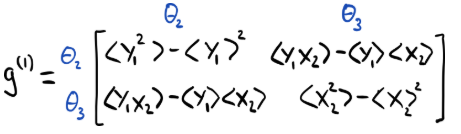

In [15]:
@qml.qnode(dev, interface="autograd")
def layer1_diag(params):
    layer1_subcircuit(params)
    return qml.var(qml.PauliY(1)), qml.var(qml.PauliX(2))

varK0, varK1 = layer1_diag(params)
g1[0, 0] = varK0 / 4
g1[1, 1] = varK1 / 4

@qml.qnode(dev, interface="autograd")
def layer1_off_diag_single(params):
    layer1_subcircuit(params)
    return qml.expval(qml.PauliY(1)), qml.expval(qml.PauliX(2))


@qml.qnode(dev, interface="autograd")
def layer1_off_diag_double(params):
    layer1_subcircuit(params)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    YX = np.kron(Y, X)
    return qml.expval(qml.Hermitian(YX, wires=[1, 2]))


# calculate the off-diagonal terms
exK0, exK1 = layer1_off_diag_single(params)
exK0K1 = layer1_off_diag_double(params)

g1[0, 1] = (exK0K1 - exK0 * exK1) / 4
g1[1, 0] = g1[0, 1]

Putting this altogether, the block-diagonal approximation to the Fubini-Study metric tensor for this VQC is 

In [16]:
from scipy.linalg import block_diag

g = block_diag(g0, g1)
print(np.round(g, 8))

[[ 0.125       0.          0.          0.        ]
 [ 0.          0.1875      0.          0.        ]
 [ 0.          0.          0.24973433 -0.01524701]
 [ 0.          0.         -0.01524701  0.20293623]]


PennyLane constains a built-in function for computing the Fubini-Study metric tensor, ```metric_tensor()```, which we can use to verify this result:

In [17]:
print(np.round(qml.metric_tensor(circuit, approx="block-diag")(params), 8))

[[ 0.125       0.          0.          0.        ]
 [ 0.          0.1875      0.          0.        ]
 [ 0.          0.          0.24973433 -0.01524701]
 [ 0.          0.         -0.01524701  0.20293623]]


수동으로 구할 때는 총 6번 계산했지만, PennyLane의 metric tensor를 쓰면 layer 당 1번으로, 오직 2번만 계산하면 됨. (자동으로 레이어를 식별함)  

따라서, by combining the quantum natural gradient optimizer with the analytic parameter-shift rulte to optimize a VQC widh $d$ parameters and $L$ parametrized layers, a total of $2d+L$ quantum evaluations are required per optimization step

```metric_tensor()```은 diagonal approximation 계산에도 사용됨

In [18]:
print(qml.metric_tensor(circuit, approx='diag')(params))

[[0.125      0.         0.         0.        ]
 [0.         0.1875     0.         0.        ]
 [0.         0.         0.24973433 0.        ]
 [0.         0.         0.         0.20293623]]


the returned metric tensor is **full differentiable**; include it in your cost function and train or optimize its value!

## Quantum natural gradient optimization  
PennyLane은 ```QNGOptimizaer```를 지원함. ```GradientDescentOptimizer```와 비교해보자

In [25]:
steps = 200
init_params = pnp.array([0.432, -0.123, 0.543, 0.233], requires_grad=True)

In [24]:
gd_cost = []
opt = qml.GradientDescentOptimizer(0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    gd_cost.append(circuit(theta))
print(theta)

[-0.04508702 -0.81198437  0.96883044  0.233     ]


In [26]:
qng_cost = []
opt = qml.QNGOptimizer(0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    qng_cost.append(circuit(theta))
print(theta)

[-0.02154685 -1.56562442  1.54674389  0.70526456]


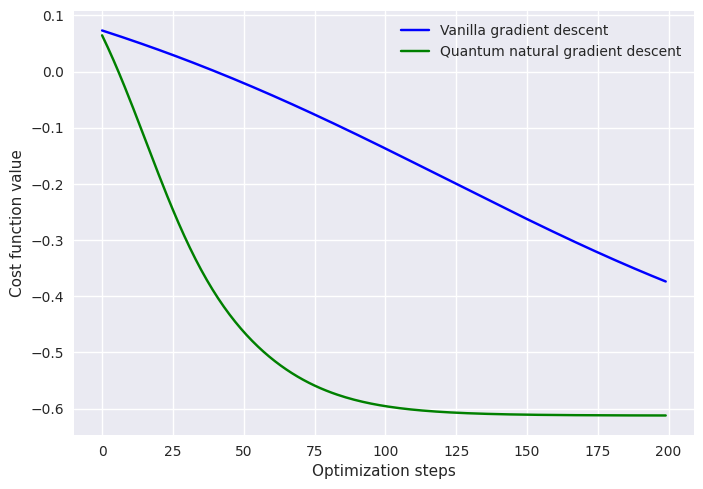

In [27]:
from matplotlib import pyplot as plt

plt.style.use("seaborn-v0_8")
plt.plot(gd_cost, "b", label="Vanilla gradient descent")
plt.plot(qng_cost, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

## 정리

### 1. 동력원: 생성자 (Generator, $K$)

양자 회로에서 매개변수 가 변할 때, 양자 상태 를 변화시키는 실제 물리적 연산자가 바로 생성자입니다.

가변 게이트 $U(\theta)$는 보통 다음과 같이 표현됩니다.
$$U(\theta) = \exp(-i\theta K)$$

여기서 는 에르미트 연산자(Hermitian operator)인 **생성자**입니다.

* **물리적 의미**: 상태 $|\psi\rangle$가 매개변수  $\theta$방향으로 움직일 때의 '속도' 혹은 '운동량'을 결정합니다.
* **수식에서의 역할**: 상태의 미분값은  $\partial_i |\psi\rangle = -i K_i |\psi\rangle$와 같이 생성자와 직결됩니다.

### 2. 지도: 푸비니-스터디 메트릭 (Fubini-Study Metric, $g_{ij}$)

우리는 매개변수 $\theta$를 바꿈으로써 상태를 이동시킵니다. 이때 우리가 느끼는 거리($d\theta$)와 실제 양자 상태가 느끼는 거리($ds$) 사이의 관계를 정의해 주는 것이 **메트릭 텐서** 입니다.

두 양자 상태 사이의 거리는 다음과 같이 정의됩니다.
$$ds^2 = 1 - |\langle \psi(\theta) | \psi(\theta + d\theta) \rangle|^2 \approx \sum_{i,j} g_{ij} d\theta_i d\theta_j$$

이 식을 전개하면 푸비니-스터디 메트릭 성분 $g_{ij}$는 생성자들의 **공분산(Covariance)** 형태가 됩니다.
$$g_{ij} = \langle \psi | K_i K_j | \psi \rangle - \langle \psi | K_i | \psi \rangle \langle \psi | K_j | \psi \rangle$$

* **물리적 의미**: 이 행렬은 현재 지형의 **곡률(Curvature)**을 나타냅니다.
* **수식에서의 역할**: $g_{ii}$가 크면 해당 방향($\theta_i$)으로 조금만 움직여도 상태가 급변하고, $g_{ii}$가 작으면 상태가 거의 변하지 않는 평탄한 지형임을 의미합니다.

### 3. 운전대: 유사 역행렬 (Pseudo-inverse, $g^+$)

이제 어디가 절벽이고 어디가 평지인지 알았으니, 실제 이동 방향을 결정해야 합니다. 일반적인 경사 하강법은 지형을 무시하고  $-\nabla L$방향으로 직진하지만, 자연 경사 하강법은 이 방향을 메트릭 g로 교정합니다.

업데이트 공식은 다음과 같습니다.
$$\theta_{t+1} = \theta_t - \eta g^+ \nabla L(\theta)$$

여기서 왜 그냥 역행렬($g^{-1}$)이 아닌 **유사 역행렬($g^+$)**을 쓸까요?

* **수학적 이유**: 양자 회로에서 일부 매개변수는 상태 변화에 기여하지 않을 수 있어 g의 행렬식(Determinant)이 0이 되는 경우가 흔합니다. 이때 일반적인 역행렬은 정의되지 않습니다.
* **물리적 의미**: 유사 역행렬은 정보가 소실된 방향(고윳값이 0인 방향)은 무시하고, **정보가 살아있는 유효한 공간 내에서만 최적의 경로**를 찾아주는 영점 조절 장치 역할을 합니다.


### 종합: 하나의 이야기로 연결하기

1. **생성자($K$)**라는 엔진이 양자 상태를 밀어내면,
2. 그 밀려나는 정도를 측정해 힐베르트 공간의 곡률 지도인 **푸비니-스터디 메트릭($g$)**을 그립니다.
3. 이 지도는 상태가 민감하게 변하는 곳에선 조심하고, 둔감한 곳에선 과감하게 움직이도록 정보를 줍니다.
4. 마지막으로 **유사 역행렬($g^+$)**을 통해 수치적으로 불안정한 구간을 정제하여, 가장 효율적으로 손실 함수 $L$을 줄이는 최단 경로를 따라 항해하게 됩니다.

결국 **QNG**는 "매개변수의 수치적 변화에 속지 말고, 실제 양자 상태의 물리적 변화를 기준으로 움직여라"라는 철학을 수학적으로 구현한 것


## Appendix A. 어떻게 테일러 전개를 하는가?
우리의 출발점은 두 양자 상태 사이의 거리(정확히는 $1 - \text{Fidelity}$)인 $ds^2$ 정의입니다.$$ds^2 = 1 - |\langle \psi(\theta) | \psi(\theta + d\theta) \rangle|^2$$

1. 상태 $|\psi(\theta + d\theta)\rangle$의 테일러 전개$\theta$에 대해 2차항까지 전개하면 다음과 같습니다 (여기서 $\partial_i$는 $\frac{\partial}{\partial \theta_i}$를 의미합니다).$$|\psi(\theta + d\theta)\rangle \approx |\psi\rangle + \sum_i \partial_i |\psi\rangle d\theta_i + \frac{1}{2} \sum_{i,j} \partial_i \partial_j |\psi\rangle d\theta_i d\theta_j$$

2. 내적 $\langle \psi | \psi(\theta + d\theta) \rangle$ 계산상태의 규격화 조건($\langle \psi | \psi \rangle = 1$)을 이용하여 내적을 구합니다.$$\langle \psi | \psi(\theta + d\theta) \rangle \approx 1 + \sum_i \langle \psi | \partial_i \psi \rangle d\theta_i + \frac{1}{2} \sum_{i,j} \langle \psi | \partial_i \partial_j \psi \rangle d\theta_i d\theta_j$$계산을 단순화하기 위해 각 항을 다음과 같이 정의합시다.
* $A = \sum_i \langle \psi | \partial_i \psi \rangle d\theta_i$
* $B = \frac{1}{2} \sum_{i,j} \langle \psi | \partial_i \partial_j \psi \rangle d\theta_i d\theta_j$그러면 내적은 $1 + A + B$가 됩니다.

3. 절댓값 제곱 $|\langle \psi | \psi(\theta + d\theta) \rangle|^2$ 전개$|1 + A + B|^2 = (1 + A + B)(1 + A^* + B^)$를 전개합니다. 우리는 $d\theta$의 2차항까지만 남길 것이므로, $AB$나 $BB^*$ 같은 고차항은 무시합니다.$$|1 + A + B|^2 \approx 1 + (A + A^*) + (AA^* + B + B^*)$$

4. 규격화 조건의 미분 활용여기서 $A + A$와 $B + B$를 물리적으로 해석해야 합니다. $\langle \psi | \psi \rangle = 1$을 매개변수로 미분해 봅시다.
1. 1차 미분: $\partial_i \langle \psi | \psi \rangle = \langle \partial_i \psi | \psi \rangle + \langle \psi | \partial_i \psi \rangle = 0$
* 따라서 $\langle \psi | \partial_i \psi \rangle$는 순허수이며, 이로 인해 $A + A^* = 0$이 되어 1차항이 사라집니다.
2. 2차 미분: $\partial_j \partial_i \langle \psi | \psi \rangle = 0$
* 이 식을 전개하면 $\langle \partial_j \partial_i \psi | \psi \rangle + \langle \partial_i \psi | \partial_j \psi \rangle + \langle \partial_j \psi | \partial_i \psi \rangle + \langle \psi | \partial_j \partial_i \psi \rangle = 0$가 됩니다.
* 이를 $B$의 형태로 정리하면 $B + B^* = -\frac{1}{2} \sum_{i,j} (\langle \partial_i \psi | \partial_j \psi \rangle + \langle \partial_j \psi | \partial_i \psi \rangle) d\theta_i d\theta_j$입니다.

5. 최종 $ds^2$ 도출이제 모든 것을 $ds^2 = 1 - |1 + A + B|^2$에 대입합니다.$$ds^2 \approx 1 - (1 + 0 + AA^* + B + B^*) = -AA^* - (B + B^*)$$
각 항을 다시 대입하면:
$$-AA^* = -(\sum_i \langle \psi | \partial_i \psi \rangle d\theta_i)(\sum_j \langle \partial_j \psi | \psi \rangle d\theta_j) = \sum_{i,j} \langle \partial_j \psi | \psi \rangle \langle \psi | \partial_i \psi \rangle d\theta_i d\theta_j$$
$$-(B + B^*) = \sum_{i,j} \text{Re} \langle \partial_i \psi | \partial_j \psi \rangle d\theta_i d\theta_j$$따라서 $ds^2 = \sum_{i,j} g_{ij} d\theta_i d\theta_j$ 꼴로 묶으면 메트릭 성분 $g_{ij}$는 다음과 같습니다.$$g_{ij} = \text{Re} \langle \partial_i \psi | \partial_j \psi \rangle - \langle \partial_i \psi | \psi \rangle \langle \psi | \partial_j \psi \rangle$$

6. 생성자 $K$로의 변환마지막으로 $\partial_i |\psi\rangle = -i K_i |\psi\rangle$를 대입해 보겠습니다.
* $\langle \partial_i \psi | \partial_j \psi \rangle = \langle \psi | (i K_i) (-i K_j) | \psi \rangle = \langle \psi | K_i K_j | \psi \rangle$
* $\langle \partial_i \psi | \psi \rangle = i \langle \psi | K_i | \psi \rangle$
* $\langle \psi | \partial_j \psi \rangle = -i \langle \psi | K_j | \psi \rangle$
이를 $g_{ij}$ 식에 넣으면 익숙한 공분산 형태가 나옵니다!
$$g_{ij} = \langle K_i K_j \rangle - \langle K_i \rangle \langle K_j \rangle$$